# **Crime in San Fransico Doesn't Always Occur at Night**
**30 August 2023**

You would perhaps think many crimes tend to happen at night when less people are around to witness the act. However, as it turns out, that's not always a criminal's preferred time of day. In this notebook, 12 months of incident report data between 1 June 2022 and 31 May 2023 from San Francisco's open data portal [https://data.sfgov.org](https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783) was analysed. The original brief called for an analysis of the same incident dataset, but of three months in 2014. Since that was nine years ago, and computing power has increased significantly since then, the author decided to widen the time period of analysis and use far more recent data.

Whilst there were a number of possible areas of investigation, this analysis focussed on time of day patterns. This included determining when most crimes tended to occur and a more granular breakdown by crime type. The key finding from this analysis was that over a 24 hour period, the majority of crime actually occurred at midday (7.1%) followed by 6pm and 5pm (both 5.9%). Around 5.6% of crime occurred at midnight.

In [12]:
# import all necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pandas.api.types import CategoricalDtype

In [118]:
incidents = pd.read_csv('sf_incidents_2223.csv')
# clean up the column names
incidents.columns = incidents.columns.str.lower().str.replace(' ', '_')
incidents.columns = incidents.columns.str.replace('incident_', '')
# select the columns for analysis
incidents = incidents.loc[:, ['row_id', 'datetime', 'date', 'time', 'code', 'category', 'subcategory', 'description']]

# convert datetime from an object to datetime type
incidents['datetime'] = pd.to_datetime(incidents.datetime, infer_datetime_format = True)
incidents['date'] = pd.to_datetime(incidents.date, infer_datetime_format = True)

# add hour information
incidents['hour_num'] = incidents.datetime.dt.hour
hour_dict = {0: '12 AM',
             1: '1 AM',
             2: '2 AM',
             3: '3 AM',
             4: '4 AM',
             5: '5 AM',
             6: '6 AM',
             7: '7 AM',
             8: '8 AM',
             9: '9 AM',
             10: '10 AM',
             11: '11 AM',
             12: '12 PM',
             13: '1 PM',
             14: '2 PM',
             15: '3 PM',
             16: '4 PM',
             17: '5 PM',
             18: '6 PM',
             19: '7 PM',
             20: '8 PM',
             21: '9 PM',
             22: '10 PM',
             23: '11 PM'}
incidents['hour'] = incidents.hour_num.map(hour_dict)
cat_type = CategoricalDtype(categories=['12 AM', '1 AM', '2 AM', '3 AM', '4 AM', '5 AM', '6 AM',
                                        '7 AM', '8 AM', '9 AM', '10 AM', '11 AM', '12 PM', '1 PM',
                                        '2 PM', '3 PM', '4 PM', '5 PM',  '6 PM', '7 PM',
                                        '8 PM', '9 PM', '10 PM', '11 PM'], ordered=True)
incidents.hour = incidents.hour.astype(cat_type)

# add time of day information
incidents['time_of_day'] = np.where(incidents.hour_num < 4, '12AM - 3AM',
                            np.where((incidents.hour_num >= 4) & (incidents.hour_num < 8), '4AM - 7AM',
                            np.where((incidents.hour_num >= 8) & (incidents.hour_num < 12), '8AM - 11AM',
                            np.where((incidents.hour_num >= 12) & (incidents.hour_num < 16), '12PM - 3PM',
                            np.where((incidents.hour_num >= 16) & (incidents.hour_num < 20), '4PM - 7PM',
                            np.where(incidents.hour_num >= 20, '8PM - 11PM', 'TBC'))))))
cat_type = CategoricalDtype(categories=["12AM - 3AM", "4AM - 7AM", "8AM - 11AM", "12PM - 3PM",
                                        "4PM - 7PM", "8PM - 11PM"], ordered=True)
incidents.time_of_day = incidents.time_of_day.astype(cat_type)

incidents['time_of_day2'] = np.where(incidents.hour_num < 5, 'night',
                            np.where((incidents.hour_num >= 5) & (incidents.hour_num < 8), 'early morning',
                            np.where((incidents.hour_num >= 8) & (incidents.hour_num < 11), 'morning',
                            np.where((incidents.hour_num >= 11) & (incidents.hour_num < 12), 'late morning',
                            np.where((incidents.hour_num >= 12) & (incidents.hour_num < 15), 'early afternoon',
                            np.where((incidents.hour_num >= 15) & (incidents.hour_num < 16), 'afternoon',
                            np.where((incidents.hour_num >= 16) & (incidents.hour_num < 17), 'late afternoon',
                            np.where((incidents.hour_num >= 17) & (incidents.hour_num < 19), 'early evening',
                            np.where((incidents.hour_num >= 19) & (incidents.hour_num < 21), 'evening',
                            np.where(incidents.hour_num >= 21, 'night', 'TBC'))))))))))
cat_type = CategoricalDtype(categories=["early morning", "morning", "late morning", "early afternoon",
                                        "afternoon", "late afternoon", "early evening", "evening",
                                        "night"], ordered=True)
incidents.time_of_day2 = incidents.time_of_day2.astype(cat_type)

# clean up the incident categories
incidents['category_semiclean'] = np.where(incidents.category == 'Other Miscellaneous', 'Other',
                                  np.where(incidents.category == 'Motor Vehicle Theft?', 'Motor Vehicle Theft',
                                  np.where(incidents.category == 'Human Trafficking (A), Commercial Sex Acts', 'Human Trafficking, Commercial Sex Acts',
                                  np.where(incidents.category == 'Weapons Offence', 'Weapons Offense',
                                  np.where(incidents.category == 'Suspicious', 'Suspicious Occ',
                                           incidents.category)))))

# collapse the primary categories into something useful
incidents.category_semiclean.value_counts()
incidents['category_clean'] = np.where(incidents.category_semiclean == 'Larceny Theft', 'Larceny/Theft',
                              np.where(incidents.category_semiclean == 'Malicious Mischief', 'Malicious Mischief/Damage',
                              np.where(incidents.category_semiclean == 'Motor Vehicle Theft', 'Motor Vehicle-Related',
                              np.where(incidents.category_semiclean == 'Recovered Vehicle', 'Motor Vehicle-Related',
                              np.where(incidents.category_semiclean == 'Drug Offense', 'Drug/Narcotics-Related',
                              np.where(incidents.category_semiclean == 'Weapons Offense', 'Weapons-Related',
                              np.where(incidents.category_semiclean == 'Traffic Violation Arrest', 'Motor Vehicle-Related',
                              np.where(incidents.category_semiclean == 'Weapons Carrying Etc', 'Motor Vehicle-Related',
                              np.where(incidents.category_semiclean == 'Stolen Property', 'Larceny/Theft',
                              np.where(incidents.category_semiclean == 'Courtesy Report', 'Non-Criminal',
                              np.where(incidents.category_semiclean == 'Case Closure', 'Non-Criminal',
                              np.where(incidents.category_semiclean == 'Vandalism', 'Malicious Mischief/Damage',
                              np.where(incidents.category_semiclean == 'Traffic Collision', 'Motor Vehicle-Related',
                              np.where(incidents.category_semiclean == 'Forgery And Counterfeiting', 'Fraud',
                              np.where(incidents.category_semiclean == 'Fire Report', 'Arson',
                              np.where(incidents.category_semiclean == 'Embezzlement', 'Fraud',
                              np.where(incidents.category_semiclean == 'Sex Offense', 'Sex Offense-Related',
                              np.where(incidents.category_semiclean == 'Vehicle Impounded', 'Motor Vehicle-Related',
                              np.where(incidents.category_semiclean == 'Vehicle Misplaced', 'Motor Vehicle-Related',
                              np.where(incidents.category_semiclean == 'Drug Violation', 'Drug/Narcotics-Related',
                              np.where(incidents.category_semiclean == 'Prostitution', 'Sex Offense-Related',
                              np.where(incidents.category_semiclean == 'Rape', 'Sex Offense-Related',
                              np.where(incidents.category_semiclean == 'Human Trafficking, Commercial Sex Acts', 'Sex Offense-Related',
                              np.where(incidents.category_semiclean == 'Lost Property', 'Larceny/Theft',
                              np.where(incidents.category_semiclean == 'Suspicious Occ', 'Suspicious Occurrence',
                              np.where(incidents.category_semiclean == 'Offences Against The Family And Children', 'Domestic Violence',
                              np.where(incidents.category_semiclean == 'Gambling', 'Other',
                              np.where(incidents.category_semiclean == 'Civil Sidewalks', 'Other',
                                       incidents.category_semiclean))))))))))))))))))))))))))))

# incidents.category_clean.value_counts()
incidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136677 entries, 0 to 136676
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   row_id              136677 non-null  int64         
 1   datetime            136677 non-null  datetime64[ns]
 2   date                136677 non-null  datetime64[ns]
 3   time                136677 non-null  object        
 4   code                136677 non-null  int64         
 5   category            136545 non-null  object        
 6   subcategory         136545 non-null  object        
 7   description         136677 non-null  object        
 8   hour_num            136677 non-null  int64         
 9   hour                136677 non-null  category      
 10  time_of_day         136677 non-null  category      
 11  time_of_day2        136677 non-null  category      
 12  category_semiclean  136545 non-null  object        
 13  category_clean      136545 no

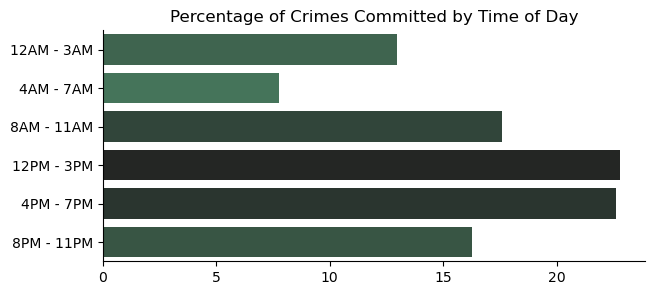

In [173]:
by_tod = pd.DataFrame(incidents.time_of_day.value_counts(normalize=True)).reset_index()
by_tod.time_of_day = by_tod.time_of_day * 100
by_tod.sort_values(by='index', inplace=True)

values = by_tod.time_of_day
custom_palette = sns.dark_palette("seagreen", len(values), reverse=True)
colour_mapping = dict(zip(sorted(values), custom_palette))
colour_mapping

fig, ax = plt.subplots(figsize=(7,3))
sns.barplot(data=by_tod, x='time_of_day', y='index',
            palette=[colour_mapping[val] for val in values], saturation=0.5)
ax.set(title='Percentage of Crimes Committed by Time of Day',
       xlabel = None,
       ylabel = None)
sns.despine()

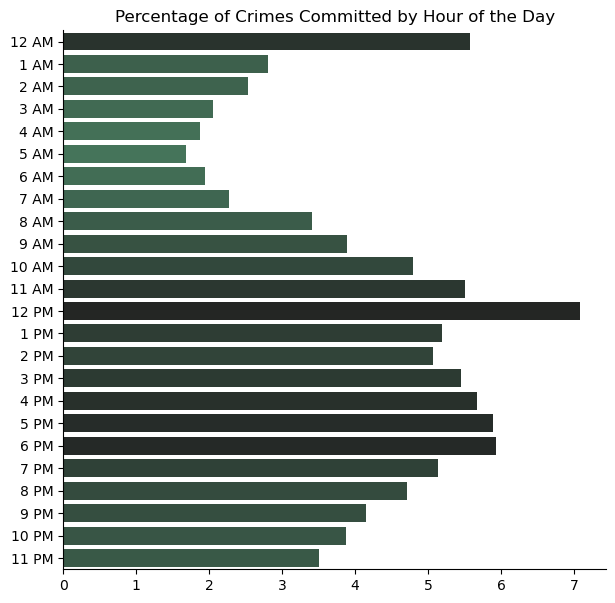

In [174]:
by_hour = pd.DataFrame(incidents.hour.value_counts(normalize=True)).reset_index()
by_hour.hour = by_hour.hour * 100
by_hour.sort_values(by='index', inplace=True)

values = by_hour.hour
custom_palette = sns.dark_palette("seagreen", len(values), reverse=True)
colour_mapping = dict(zip(sorted(values), custom_palette))
colour_mapping

fig, ax = plt.subplots(figsize=(7,7))
sns.barplot(data=by_hour, x='hour', y='index',
            palette=[colour_mapping[val] for val in values], 
            saturation=0.5, orient='h')
ax.set(title='Percentage of Crimes Committed by Hour of the Day',
       xlabel = None,
       ylabel = None)
sns.despine()

In [175]:
by_hour

,index,hour
4,12 AM,5.569335
17,1 AM,2.802959
18,2 AM,2.532979
20,3 AM,2.052284
22,4 AM,1.879614
23,5 AM,1.675483
21,6 AM,1.941073
19,7 AM,2.271779
16,8 AM,3.402182
13,9 AM,3.892389


There are multiple records for each unit incident id/number. The plot below clearly indicates that most incidents only have a single record attached to them, but about 10% (16,617) have up to 4 records. The documentation indicates that a single incident report can have one or more incident codes attached; for example if the police officer discovers narcotics whilst making an arrest (for a non-narcotics related issue), then both an arrest and narcotics incident code would be reported against the same report id. Unless otherwise specified, the analysis will be at the incident code, rather than report level.

In [6]:
counts = pd.DataFrame(incidents.id.value_counts()).reset_index()
counts = counts.groupby("id").count().reset_index()
counts['prop'] = counts['index'] / incidents.shape[0] * 100
counts.columns = ["id_count", "count", "prop"]

fig = px.bar(data_frame=counts, x="id_count", y="prop",
             hover_data={'prop':':.2f',
                         'count':':,'},
             labels={'prop':'Percentage (%)', 'id_count':'Occurrence'},
             title='Proportion of records by incident id occurrence',
             template='simple_white')
fig.update_layout(width=700, height=500) 
fig.show(renderer='iframe')

In [7]:
# clean up the incident categories
incidents['category_new'] = np.where(incidents.category == 'Other Miscellaneous', 'Other',
                                     np.where(incidents.category == 'Motor Vehicle Theft?', 'Motor Vehicle Theft',
                                     np.where(incidents.category == 'Human Trafficking (A), Commercial Sex Acts', 'Human Trafficking, Commercial Sex Acts',
                                     np.where(incidents.category == 'Weapons Offence', 'Weapons Offense',
                                     np.where(incidents.category == 'Suspicious', 'Suspicious Occ',
                                     incidents.category)))))

The plot below indicates that the most common incident reported in the twelve months between 1 June 2022 and 31 May 2023 was larceny/theft (30.9%). The secondmost common incident category reported was 'Other' (6.9%), and malicious mischief (6.7%), assault (6.4%) and motor vehicle theft (6.3%) rounded out the top 5.

At the opposite end of the spectrum, the least common incidents included civil sidewalks, gambling, human trafficking/commercial sex acts, rape and homicide.

In [8]:
by_cat = pd.DataFrame(incidents.category_new.value_counts())
by_cat.reset_index(inplace=True)
by_cat.columns = ['category', 'count']
by_cat['prop'] = by_cat['count']/incidents.shape[0]*100
by_cat.sort_values(by='prop', inplace=True)

fig = px.bar(data_frame=by_cat[-20:], x='prop', y='category',
             hover_data={'prop':':.2f',
                         'count':':,'},
             labels={'prop':'Percentage (%)', 'category':'Category'},
             title='Proportion of top 20 incidents by category',
             template='simple_white')
fig.update_layout(width=1000) 
fig

This next plot indicates that there are no drastic changes in the profile of incident categories over time. However, it is interesting to note that non-motor vehicle larceny/theft is at its lowest in May and gradually increases to a peak in December. In contrast, drug offenses are highest in July, August and February.

In [9]:
# let's see if there is any pattern in the number of incidents by month of the year
by_month = pd.DataFrame(incidents.groupby(['month', 'month_num', 'category_new'])['id'].count())
by_month.reset_index(inplace=True)
by_month.columns = ['month', 'month_num', 'category', 'count']
by_month['month_sum'] = by_month.groupby('month')['count'].transform('sum')
by_month['total_prop'] = by_month['count']/incidents.shape[0]*100
by_month['month_prop'] = by_month['count']/by_month.month_sum*100

plot_data = by_month.sort_values(by=['month_num', 'month_prop'], ascending=[True, False])
fig = px.bar(plot_data, x='month', y='month_prop', color='category',
             hover_data={'month_prop':':.2f',
                         'count':':,'},
             labels={'month':'Month', 'month_prop':'Percentage (%)', 'category':'Category'},
             title='Proportion of incidents by category and calendar month',
             template='simple_white')
fig.update_layout(height=700)
fig

Now, the following two plots are far more interesting as they indicates some clear patterns regarding when certain types of incidents are most likely to occur. For example, larceny/theft incidents spiked in the late morning from about 10am and again in the early evening/evening between 6pm and 8pm. Similarly:

- burgleries typically occurred at night or in the early morning between 3am and 6am
- vandalism (malicious mischief) typically occurred when it was darker between about 8pm and 6am the following morning
- motor vehicle thefts were more prevalent in the evening from about 5pm onwards until midnight
- fraud incidents were most likely to occur just after midnight
- robberies between 4pm in the afternoon and 6am the following morning, and
- drug offenses overwhelmingly in the daylight hours between 7am and 7pm.

In [10]:
# add parts of the day
incidents['part_of_day'] = np.where(incidents.hour < 5, 'night',
                                    np.where((incidents.hour >= 5) & (incidents.hour < 8), 'early morning',
                                    np.where((incidents.hour >= 8) & (incidents.hour < 11), 'morning',
                                    np.where((incidents.hour >= 11) & (incidents.hour < 12), 'late morning',
                                    np.where((incidents.hour >= 12) & (incidents.hour < 15), 'early afternoon',
                                    np.where((incidents.hour >= 15) & (incidents.hour < 16), 'afternoon',
                                    np.where((incidents.hour >= 16) & (incidents.hour < 17), 'late afternoon',
                                    np.where((incidents.hour >= 17) & (incidents.hour < 19), 'early evening',
                                    np.where((incidents.hour >= 19) & (incidents.hour < 21), 'evening',
                                    np.where(incidents.hour >= 21, 'night', 'TBC'))))))))))

part_of_day_dict = {'early morning': 1,
                 'morning': 2,
                 'late morning': 3,
                 'early afternoon': 4,
                 'afternoon': 5,
                 'late afternoon': 6,
                 'early evening': 7,
                 'evening': 8,
                 'night': 9}
incidents['part_of_day_num'] = incidents.part_of_day.map(part_of_day_dict)

by_part_of_day = pd.DataFrame(incidents.groupby(['part_of_day', 'part_of_day_num', 'category_new'])['id'].count())
by_part_of_day.reset_index(inplace=True)
by_part_of_day.columns = ['part_of_day', 'part_of_day_num', 'category', 'count']
by_part_of_day['day_sum'] = by_part_of_day.groupby('part_of_day')['count'].transform('sum')
by_part_of_day['total_prop'] = by_part_of_day['count']/incidents.shape[0]*100
by_part_of_day['part_prop'] = by_part_of_day['count']/by_part_of_day.day_sum*100

plot_data = by_part_of_day.sort_values(by=['part_of_day_num', 'part_prop'], ascending=[True, False])
fig = px.bar(plot_data, x='part_of_day', y='part_prop', color='category',
             hover_data={'part_prop':':.2f',
                         'count':':,'},
             labels={'part_of_day':'Hour', 'part_prop':'Percentage (%)', 'category':'Category'},
             title='Proportion of incidents by category and part of the day',
             template='simple_white')
fig.update_layout(height=700)
fig

In [11]:
by_hour = pd.DataFrame(incidents.groupby(['hour', 'category_new'])['id'].count())
by_hour.reset_index(inplace=True)
by_hour.columns = ['hour', 'category', 'count']
by_hour['day_sum'] = by_hour.groupby('hour')['count'].transform('sum')
by_hour['total_prop'] = by_hour['count']/incidents.shape[0]*100
by_hour['hour_prop'] = by_hour['count']/by_hour.day_sum*100

plot_data = by_hour.sort_values(by=['hour', 'hour_prop'], ascending=[True, False])
fig = px.bar(plot_data, x='hour', y='hour_prop', color='category',
             hover_data={'hour_prop':':.2f',
                         'count':':,'},
             labels={'hour':'Hour', 'hour_prop':'Percentage (%)', 'category':'Category'},
             title='Proportion of incidents by category and hour',
             template='simple_white')
fig.update_layout(height=700)
fig

In [12]:
by_police_district = pd.DataFrame(incidents.groupby(['police_district', 'category_new'])['id'].count())
by_police_district.reset_index(inplace=True)
by_police_district.columns = ['district', 'category', 'count']
by_police_district['district_sum'] = by_police_district.groupby('district')['count'].transform('sum')
by_police_district['district_prop'] = by_police_district['count']/by_police_district.district_sum*100

plot_data = by_police_district.sort_values(by=['district', 'district_prop'], ascending=[True, False])
fig = px.bar(plot_data, x='district', y='district_prop', color='category',
             hover_data={'district_prop':':.2f',
                         'count':':,'},
             labels={'district':'Police District', 'district_prop':'Percentage (%)', 'category':'Category'},
             title='Proportion of incidents by category and police district',
             template='simple_white')
fig.update_layout(height=700)
fig

In [13]:
by_supervisor_district = pd.DataFrame(incidents.groupby(['supervisor_district', 'category_new'])['id'].count())
by_supervisor_district.reset_index(inplace=True)
by_supervisor_district.columns = ['district', 'category', 'count']
by_supervisor_district['district_sum'] = by_supervisor_district.groupby('district')['count'].transform('sum')
by_supervisor_district['district_prop'] = by_supervisor_district['count']/by_supervisor_district.district_sum*100

plot_data = by_supervisor_district.sort_values(by=['district', 'district_prop'], ascending=[True, False])
fig = px.bar(plot_data, x='district', y='district_prop', color='category',
             hover_data={'district_prop':':.2f',
                         'count':':,'},
             labels={'district':'Supervisor District', 'district_prop':'Percentage (%)', 'category':'Category'},
             title='Proportion of incidents by category and supervisor district',
             template='simple_white')
fig.update_layout(height=700)
fig

In [14]:
by_neighbourhood = pd.DataFrame(incidents.groupby(['analysis_neighborhood', 'neighborhoods', 'category_new'])['id'].count())
by_neighbourhood.reset_index(inplace=True)
by_neighbourhood.columns = ['name', 'id', 'category', 'count']
by_neighbourhood['neighbourhood_sum'] = by_neighbourhood.groupby('name')['count'].transform('sum')
by_neighbourhood['neighbourhood_prop'] = by_neighbourhood['count']/by_neighbourhood.neighbourhood_sum*100

plot_data = by_neighbourhood.sort_values(by=['name', 'neighbourhood_prop'], ascending=[True, False])
fig = px.bar(plot_data, x='name', y='neighbourhood_prop', color='category',
             hover_data={'neighbourhood_prop':':.2f',
                         'count':':,'},
             labels={'name':'Neighbourhood', 'neighbourhood_prop':'Percentage (%)', 'category':'Category'},
             title='Proportion of incidents by category and neighbourhood',
             template='simple_white')
fig.update_layout(height=700)
fig